In [1]:
# path to user functions
import sys  
sys.path.append('../Src/')

from platform import python_version

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import importlib 
from sklearn.mixture import GaussianMixture
# from sklearn.preprocessing import OrdinalEncoder
# from sklearn.cluster import DBSCAN
# from gower import gower_matrix


# import user functions
import UserUtilityFunctions as uf
import UserStatisticalFunctions as usf
import UserVisualization as uv
import UserMetricsFunctions as umf
import UserImputeFunctions as uif

# set seaborn theme
sns.set_theme()

# initializing variables
RANDOM_STATE = 1776

# print versions
print("Numpy Version: " + np.__version__)
print("Pandas Version: " + pd.__version__)
print("Seaborn Version: " + sns.__version__)
print("Matplotlib Version: " + plt.matplotlib.__version__)
print("Python Version: " + python_version())

# adjust pandas display options to max
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
# adjust pandas display options to ensure full display of content
pd.set_option('display.max_colwidth', None)

Numpy Version: 1.26.4
Pandas Version: 2.2.3
Seaborn Version: 0.13.2
Matplotlib Version: 3.9.2
Python Version: 3.9.20


### Import Dataset

In [2]:
# import data
df = pd.read_pickle("../Data/6Clean_ML_Heart_CAT.pkl")
df_both = pd.read_pickle("../Data/6Clean_ML_BOTH.pkl")
df_ordinal = pd.read_pickle("../Data/6Clean_ML_ordinal.pkl")
df_nominal = pd.read_pickle("../Data/6Clean_ML_nominal.pkl")
df_label = pd.read_pickle("../Data/6Clean_ML_label.pkl")
# print shape
print(f"Heart Dataset Rows: {df.shape[0]:,} & Columns: {df.shape[1]:,}")
print(f"Nominal Features: {df_nominal.shape[0]:,}")
print(f"Ordinal Features: {df_ordinal.shape[0]:,}")
print(f"Both Features: {df_both.shape[0]:,}")

Heart Dataset Rows: 27,494 & Columns: 108
Nominal Features: 50
Ordinal Features: 55
Both Features: 18


In [3]:
# combine two lists
allCat = df_ordinal.column.to_list() + df_nominal.column.to_list()

# insanity check
uf.symmetricDifference(set(allCat), set(df.columns.to_list()))

Symmetric difference: ['LengthOfStay', 'Survival', 'TransplantSurvivalDay']


### Drop Unwanted Label Features

#### User Function(s)

In [4]:
def HouseKeeping(data, removeColLst, dataLabel, dataOrdinal, dataNominal, display=True):
    """
    Run helper fuction for house keeping
    """
    # remove DataFrame data (house keeping)
    dataLabel = uf.removeRowUsingMask(dataLabel, removeColLst, colstr='column', string='df_label', display=display)
    dataOrdinal = uf.removeRowUsingMask(dataOrdinal, removeColLst, colstr='column',  string='df_ordinal', display=display)
    dataNominal = uf.removeRowUsingMask(dataNominal, removeColLst, colstr='column', string='df_nominal',  display=display)

    # remove features
    data = uf.removeColumn(data, removeColLst, display=display)

    return data, dataLabel, dataOrdinal, dataNominal

In [5]:
# add to removeCols list
removeCols = df_label.column.to_list()

# remove features
df, df_label, df_ordinal, df_nominal = HouseKeeping(df, removeCols, df_label, df_ordinal, df_nominal, display=True)

Remove 2 row(s) from df_label DataFrame.
Remove 0 row(s) from df_ordinal DataFrame.
Remove 0 row(s) from df_nominal DataFrame.

Removed Features: ['LengthOfStay', 'TransplantSurvivalDay']

Total Row(s) & Column(s) Before Removing Column(s): 27,494 & columns: 108
Total Row(s) & Column(s) After Removing Column(s): 27,494 & columns: 106


#### Survival Plot

In [6]:
# remove rows where Survival is NaN
df = df.dropna(subset=['Survival'])
# print
print(f"Heart Dataset Rows: {df.shape[0]:,} & Columns: {df.shape[1]:,}")

Heart Dataset Rows: 27,494 & Columns: 106


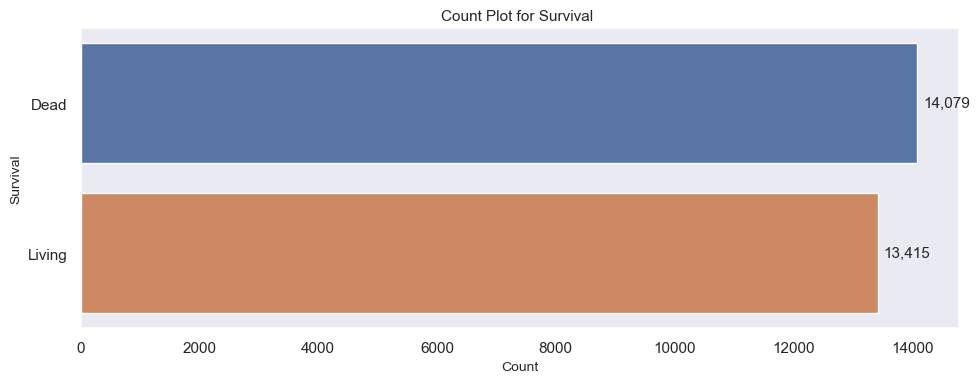

In [7]:
uv.countPlot(df, ['Survival'], figsize=(10, 4))

#### Display nominal & ordinal Data

In [8]:
# display all nominal values
df[df_nominal.column.to_list()].head()

,BloodGroupMatchLevel,InotropicAgent_DON,HeavyAlcoholUse_DON,AntiHypertensive_DON,ArginnieManagement_DON,PrimaryDiagnosisType_CAN,CauseOfDeath_DON,InfectionTherapyIV_CAN,Diabetes_DON,DiabetesType_CAN,CerebroVascularDisease_CAN,DefibrillatorImplantRegistration_CAN,IntropicMedicationProcurement_DON,CigaretteUse_CAN,CigaretteHistory_DON,StatusAtTransplant_CAN,Ethnicity_CAN,Ethnicity_DON,HeartProcedureType_CAN,TransplantRegion,Tatoos_DON,PriorLungSurgeryAfterRegistration_CAN,EpsteinBarrSeroStatusTransplant_CAN,SerologyAntiCMV_DON,CMVStatus_Transplant_CAN,HEP_C_SerostatusStatus_CAN,AntibodyResultHBSAB_DON,AntibodyResultRPR_VDRL_DON,Antibody_HEP_C_DON,DeceasedRetyped_DON,CrossMatchDone,NonHeartBeating_DON,TriiodothyronineT3_DON,ThyroxineT4_DON,PulmonaryCatheter_DON,UrinePortein_DON,CardiacArrest_DON,ChestXray_DON,CoronaryAngiogram_DON,KidneyAllocation_DON,HeparinManagement_DON,HypertensionHistory_DON,Vasodilators_DON,MyocardialInfarctionHistory_DON,InsulinManagement_DON,LV_EjectionFractionMedthod_DON,AllocationType_DON,BloodPH_CAT_DON,Citizenship_Difference,Gender_Difference
0,Identical,Unknown,No,Yes,No,DILATED MYOPATHY: IDIOPATHIC,HEAD TRAUMA,No,No,No,No,Yes,No,No,No,Hypoplastic Left Heart Syndrome; Atrioventricular Septal Defect; Other left Heart Valvar/Structural,Hispanic,Black,Orthotopic Bicaval,Region 5,Yes,No,Unknown,Positive,Positive,Negative,Unknown,Negative,Negative,No,No,No,No,No,No,No,No,Abnormal,Unknown,No,Yes,No,No,No,Yes,Echo,Local,Normal,True,True
1,Identical,Dopamine,No,No,Yes,DILATED MYOPATHY: IDIOPATHIC,HEAD TRAUMA,No,No,No,No,Yes,Yes,No,No,Transposition of the Great Arteries; Truncus Arteriosus; Congenitally Corrected Transposition (L-TGA),Hispanic,Hispanic,Orthotopic Bicaval,Region 4,No,No,Positive,Positive,Positive,Negative,Unknown,Negative,Negative,Yes,Yes,No,No,Yes,No,No,No,Abnormal,Unknown,No,Yes,No,No,No,No,Echo,Local,Alkaline,False,True
2,Identical,"Other, specify",No,No,Yes,DILATED MYOPATHY: ISCHEMIC,ANOXIA,No,No,No,No,No,Yes,No,No,Hypoplastic Left Heart Syndrome; Atrioventricular Septal Defect; Other left Heart Valvar/Structural,"White, Non-Hispanic","White, Non-Hispanic",Orthotopic Bicaval,Region 9,No,No,Positive,Negative,Negative,Negative,Unknown,Negative,Negative,No,Yes,No,No,Yes,No,No,No,Abnormal,Unknown,No,Yes,No,No,No,No,Echo,Local,Normal,True,True
3,Identical,Unknown,No,Yes,Yes,DILATED MYOPATHY: ISCHEMIC,CEREBROVASCULAR/STROKE,No,No,No,No,No,No,Yes,Yes,Hypoplastic Left Heart Syndrome; Atrioventricular Septal Defect; Other left Heart Valvar/Structural,"White, Non-Hispanic","White, Non-Hispanic",Orthotopic Bicaval,Region 9,Yes,No,Positive,Positive,Negative,Negative,Unknown,Negative,Negative,Yes,Yes,No,No,Yes,No,Yes,No,Abnormal,Normal,No,Yes,Yes,No,No,Yes,Echo,Regional,Normal,True,False
4,Identical,Unknown,No,Yes,No,DILATED MYOPATHY: IDIOPATHIC,ANOXIA,No,No,No,No,Yes,No,No,No,Hypoplastic Left Heart Syndrome; Atrioventricular Septal Defect; Other left Heart Valvar/Structural,"White, Non-Hispanic","White, Non-Hispanic",Orthotopic Bicaval,Region 11,Yes,No,Positive,Positive,Positive,Negative,Positive,Negative,Negative,Yes,Yes,No,No,Yes,No,No,Yes,Abnormal,Unknown,No,Yes,No,No,No,Yes,Echo,Local,Alkaline,True,False


In [9]:
# display all ordinal values
df[df_ordinal.column.to_list()].head()

,MismatchLevel_AMIS,MismatchLevel_HLMIS,MismatchLevel_BMIS,MismatchLevel_DRMIS,PreviousTransplantNumber_CAN,EducationLevel_CAN,FunctionalStatusTransplant_CAN,MedicalConditionTransplant_CAN,Age_CAT_CAN,Age_CAT_DON,HeightCm_CAT_CAN,HeightCm_CAT_DON,WeightKg_CAT_CAN,WeightKg_CAT_DON,BMI_CAT_CAN,BMI_CAT_DON,BloodUreaNitrogenLevel_CAT_DON,Creatinine_CAT_CAN,Creatinine_CAT_DON,DistanceFromDonorHospitaltoTXCenter_CAT,Hematocrit_CAT_DON,Hemodynamics_Mean_PA_MN_CAT_CAN,Hemodynamics_Mean_CO_CAT_CAN,IschemicTimeHour_CAT,LV_EjectionFractionPercent_CAT_DON,SOGT_AST_CAT_DON,SOGT_ALT_CAT_DON,OrganRecovery_PCO2_CAT_DON,Bilirubin_CAT_CAN,Bilirubin_CAT_DON,TotalDayWaitList_CAT_CAN,Antigen_Positive_Count_CAN,Antigen_Positive_Count_DON,Bronchoscopy_Abnormal_Count_DON,CMV_Positive_Count_CAN,Cancer_Yes_Count_DON,DrugUse_Yes_Count_DON,Dialysis_Yes_Count_CAN,Diuretics_Yes_Count_DON,EpsteinBarr_Positive_Count_DON,HBV_NAT_Positive_Count,HCV_NAT_Positive_Count,SurfaceAntigenHEP_B_Positive_Count,HIV_Positive_Count,Hepatitis_B_Positive_Count,Infection_Yes_Count_DON,IntropesIV_Yes_Count_CAN,IntropesVasodilators_Yes_Count_CAN,LifeSupport_Yes_Count_CAN,Malignancy_Yes_Count_CAN,PriorCardiacSurgery_Yes_Count_CAN,SteroidsUse_Yes_Count,Transfusion_Yes_Count,Ventilator_Yes_Count_CAN,WorkIncome_Yes_Count_CAN
0,3.0,6.0,3.0,2.0,0,4.0,1.0,3.0,0.0,1.0,3.0,3.0,1.0,3.0,2.0,4.0,2.0,2.0,2.0,1.0,1.0,3.0,1.0,3.0,2.0,3.0,2.0,2.0,2.0,1.0,0.0,6,6,0,1,0,0,0,2,1,0,0,0,0,0,2,0,5,4,0,2,0,1,2,0
1,2.0,6.0,3.0,3.0,0,3.0,9.0,1.0,0.0,1.0,7.0,3.0,1.0,1.0,2.0,2.0,3.0,3.0,2.0,0.0,1.0,3.0,1.0,2.0,2.0,2.0,3.0,1.0,1.0,1.0,3.0,6,6,0,1,0,0,0,1,1,0,0,0,0,0,2,0,0,2,0,0,0,1,0,0
2,1.0,4.0,2.0,3.0,0,4.0,2.0,2.0,1.0,0.0,4.0,2.0,2.0,1.0,4.0,2.0,2.0,3.0,2.0,0.0,1.0,3.0,1.0,1.0,2.0,3.0,3.0,2.0,1.0,1.0,1.0,6,6,0,0,0,2,0,1,0,0,0,0,0,0,2,1,9,4,0,2,1,1,3,0
3,3.0,7.0,3.0,3.0,0,3.0,8.0,1.0,2.0,2.0,6.0,1.0,2.0,3.0,4.0,4.0,3.0,2.0,3.0,2.0,2.0,2.0,1.0,2.0,2.0,3.0,3.0,2.0,1.0,1.0,3.0,6,6,0,0,1,2,0,1,1,0,0,0,0,0,4,1,0,2,0,2,1,1,2,0
4,1.0,5.0,3.0,3.0,0,5.0,9.0,1.0,2.0,0.0,3.0,6.0,1.0,3.0,2.0,4.0,3.0,2.0,3.0,1.0,1.0,2.0,1.0,2.0,2.0,3.0,3.0,1.0,1.0,1.0,1.0,6,6,0,1,0,2,0,1,1,0,0,0,0,0,2,0,0,2,0,1,1,0,0,0


In [10]:
# determine binary nominal features
binaryCat = [col for col in df[df_nominal.column.to_list()].columns if df[col].nunique() == 2]
# display
print(binaryCat)

['Citizenship_Difference', 'Gender_Difference']


### Dummy Encoding

In [11]:
# encode
df_dummy = pd.get_dummies(df, columns=df_nominal.column.to_list(), drop_first=True)
# print shape
print(f"Shape: {df_dummy.shape}")
# add columns to list
dummyCols = df_dummy.columns.tolist()
# remove label
dummyCols.remove('Survival')

Shape: (27494, 220)


In [12]:
# remove features with GiniPercent
percent = 5
holdDF = uf.computeEntropyGiniImpurity(df_dummy[dummyCols])
removeCols = holdDF.ColumnName[holdDF.GiniPercent < percent].to_list()
print(f"Number of Features to be removed: {len(removeCols)}")
holdDF.sample(20)

Number of Features to be removed: 62


,ColumnName,NumberOfCategories,Entropy,MaxEntropy,EntropyPercent,GiniImpurity,MaxGiniImpurity,GiniPercent
198,KidneyAllocation_DON_Yes,2,0.179241,1.000000,17.924082,0.052588,0.500000,10.517511
177,DeceasedRetyped_DON_No,2,0.956729,1.000000,95.672869,0.470308,0.500000,94.061541
66,AntiHypertensive_DON_Yes,2,0.914330,1.000000,91.432995,0.441803,0.500000,88.360621
84,PrimaryDiagnosisType_CAN_DILATED MYOPATHY: VIRAL,2,0.073978,1.000000,7.397833,0.017806,0.500000,3.561228
144,"Ethnicity_DON_White, Non-Hispanic",2,0.946485,1.000000,94.648458,0.463367,0.500000,92.673383
165,SerologyAntiCMV_DON_Positive,2,0.963433,1.000000,96.343281,0.474868,0.500000,94.973688
161,PriorLungSurgeryAfterRegistration_CAN_Unknown,2,0.130711,1.000000,13.071054,0.035570,0.500000,7.113984
115,DiabetesType_CAN_Yes,2,0.866822,1.000000,86.682217,0.410566,0.500000,82.113137
42,SurfaceAntigenHEP_B_Positive_Count,3,0.112494,1.584963,7.097611,0.029382,0.666667,4.407314
59,InotropicAgent_DON_Levophed,2,0.516974,1.000000,51.697377,0.204680,0.500000,40.935962


In [13]:
# features to be removed
holdDF[holdDF.ColumnName.isin(removeCols)].sample(10)

,ColumnName,NumberOfCategories,Entropy,MaxEntropy,EntropyPercent,GiniImpurity,MaxGiniImpurity,GiniPercent
162,PriorLungSurgeryAfterRegistration_CAN_Yes,2,0.037340,1.0,3.733956,0.007898,0.50,1.579514
112,Diabetes_DON_Unknown,2,0.058749,1.0,5.874926,0.013510,0.50,2.702090
210,LV_EjectionFractionMedthod_DON_Unknown,2,0.016832,1.0,1.683173,0.003123,0.50,0.624613
122,CigaretteUse_CAN_Unknown,2,0.026545,1.0,2.654536,0.005296,0.50,1.059230
72,PrimaryDiagnosisType_CAN_CONGENITAL HEART DEFECT - WITHOUT SURGERY,2,0.025922,1.0,2.592172,0.005151,0.50,1.030285
101,PrimaryDiagnosisType_CAN_RESTRICTIVE MYOPATHY: OTHER SPECIFY,2,0.030532,1.0,3.053197,0.006236,0.50,1.247268
203,Vasodilators_DON_Unknown,2,0.065712,1.0,6.571177,0.015446,0.50,3.089173
83,PrimaryDiagnosisType_CAN_DILATED MYOPATHY: POST PARTUM,2,0.096331,1.0,9.633073,0.024498,0.50,4.899552
108,CauseOfDeath_DON_Missing,2,0.002064,1.0,0.206436,0.000291,0.50,0.058186
35,Cancer_Yes_Count_DON,4,0.120990,2.0,6.049500,0.029089,0.75,3.878587


### Split Dataset

In [14]:
from sklearn.model_selection import train_test_split

# encoded DataFrame
df_dummy = df_dummy.drop(columns=removeCols)
# print shape
print(f"Heart Dataset Rows: {df_dummy.shape[0]:,} & Columns: {df_dummy.shape[1]:,}")

# house keeping
ordinalCols = list(set(df_ordinal.column.to_list()) - set(removeCols))

# split X & y
X = df_dummy.drop(columns = 'Survival')
y = df_dummy.Survival

# mapping values
y = y.map({'Dead': True, 'Living': False})

# split the dataset into 80% training and 20% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y)

Heart Dataset Rows: 27,494 & Columns: 158


### Scale

In [15]:
from sklearn.preprocessing import MinMaxScaler

# initialize MinMaxScaler
scale = MinMaxScaler()

# fit
fitScale = scale.fit(X_train[ordinalCols])

# transform
X_train[ordinalCols] = fitScale.transform(X_train[ordinalCols])
X_test[ordinalCols] = fitScale.transform(X_test[ordinalCols])

# convert bool datatypes to int
X_train[X_train.select_dtypes(include='bool').columns] = X_train.select_dtypes(include='bool').astype(int)
X_test[X_test.select_dtypes(include='bool').columns] = X_test.select_dtypes(include='bool').astype(int)
X[X.select_dtypes(include='bool').columns] = X.select_dtypes(include='bool').astype(int)

### GMM

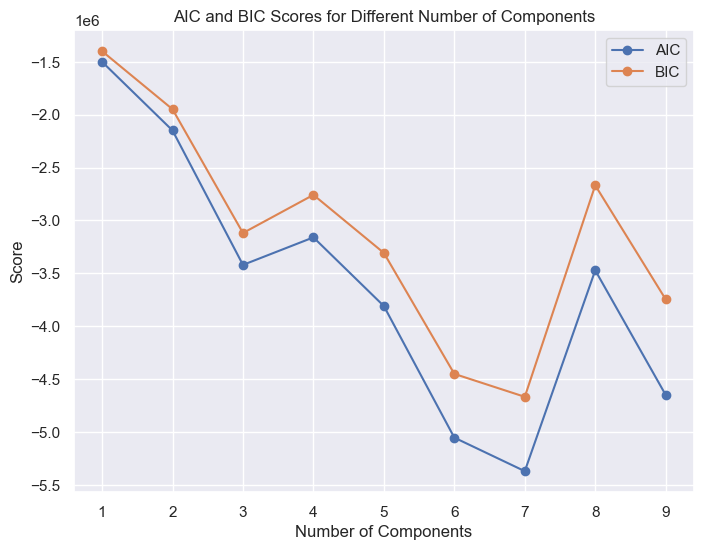

Optimal number of components: 7


In [16]:
uif.findGaussianMixtureComponents(X_train, RANDOM_STATE)

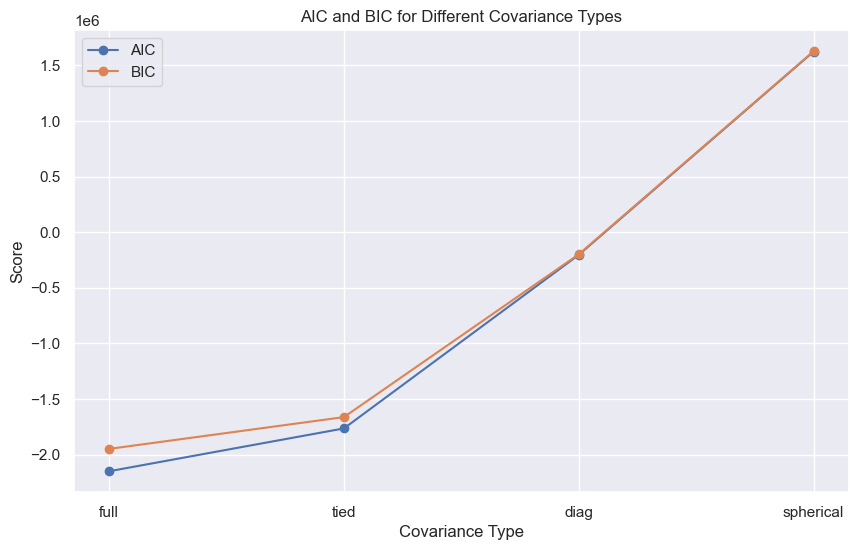

Optimal covariance type based on AIC: full


In [17]:
# covariance types to try
covariance_types = ['full', 'tied', 'diag', 'spherical']

# Function to evaluate GMM with different covariance types
def evaluate_gmm_with_covariance_types(X_train, covariance_types, n_components=2):
    aic_scores = []
    bic_scores = []
    best_models = {}

    for cov_type in covariance_types:
        gmm = GaussianMixture(n_components=n_components, covariance_type=cov_type, random_state=RANDOM_STATE)
        gmm.fit(X_train)
        
        # Store the AIC and BIC for each covariance type
        aic_scores.append(gmm.aic(X_train))
        bic_scores.append(gmm.bic(X_train))
        best_models[cov_type] = gmm

    return best_models, aic_scores, bic_scores

# evaluate GMM with different covariance types
best_models, aic_scores, bic_scores = evaluate_gmm_with_covariance_types(X_train, covariance_types, n_components=2)

# plot AIC and BIC to choose the best model
plt.figure(figsize=(10, 6))
plt.plot(covariance_types, aic_scores, label='AIC', marker='o')
plt.plot(covariance_types, bic_scores, label='BIC', marker='o')
plt.xlabel('Covariance Type')
plt.ylabel('Score')
plt.title('AIC and BIC for Different Covariance Types')
plt.legend()
plt.grid(True)
plt.show()

# choose the optimal covariance type based on AIC or BIC
optimal_covariance_type = covariance_types[np.argmin(aic_scores)]
print(f"Optimal covariance type based on AIC: {optimal_covariance_type}")

# Fit the best GMM model with the optimal covariance type
gmm_best = best_models[optimal_covariance_type]

# Predict the latent classes for the train and test sets
train_predictions = gmm_best.predict(X_train)
test_predictions = gmm_best.predict(X_test)

In [18]:
# Fit the Latent Class Analysis model (mixture model)
# Latent variables might be the number of classes you assume exist in your data
# Assuming we want to estimate 2 latent classes
k = 2  # Number of latent classes

# Fit a mixture model (Gaussian Mixture Model or similar can be applied here)
gmm = GaussianMixture(n_components=k, covariance_type='full', random_state=RANDOM_STATE)
gmm.fit(X)

# Predict the latent class (cluster) for each observation
df['predicted_class'] = gmm.predict(X)

In [19]:
df[['Survival','predicted_class']].head()

,Survival,predicted_class
0,Dead,1
1,Living,1
2,Living,0
3,Living,0
4,Living,1


In [20]:
df.Survival.value_counts(), df.predicted_class.value_counts()

(Survival
 Dead      14079
 Living    13415
 Name: count, dtype: int64,
 predicted_class
 1    20887
 0     6607
 Name: count, dtype: int64)

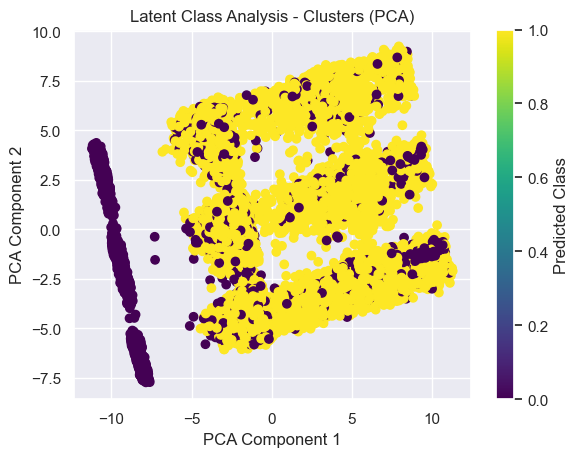

In [21]:
# Optionally, visualize the cluster assignments for the first two features
# Since the number of features is more than 2, you can visualize using PCA or just the first 2 dimensions for simplicity
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=df['predicted_class'], cmap='viridis')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('Latent Class Analysis - Clusters (PCA)')
plt.colorbar(label='Predicted Class')
plt.show()

#### Gower distance differs from other distance metrics in several significant ways, especially in its ability to handle mixed data types.
1. Handling Mixed Data Types
    - Gower Distance: Specifically designed for datasets with mixed data types (numerical, categorical, binary, ordinal, etc.). It calculates distances differently for each type of variable and combines them into a single similarity score.

    - Other Distance Metrics:
        - Euclidean Distance: Works only with numerical data and assumes all features are on the same scale.
        - Manhattan Distance: Similar to Euclidean but uses absolute differences; still limited to numerical data.
        - Hamming Distance: Only applicable to binary or categorical data.

2. Normalization
    - Gower Distance: Normalizes numerical features by dividing the absolute difference by the feature’s range ($R_k$), ensuring all variables contribute equally regardless of scale.
        - Other Distance Metrics:
            - Euclidean and Manhattan distances require explicit normalization (e.g., MinMaxScaler or StandardScaler) before computation; otherwise, features with larger ranges dominate the result.

3. Categorical Data Handling
- Gower Distance: Assigns a similarity score of 1 if two categorical values are the same and 0 if they differ. This makes it ideal for datasets with nominal variables.
    - Other Distance Metrics:
        - Euclidean or Manhattan distances require one-hot encoding of categorical variables, which can disproportionately weight rare categories or inflate dimensionality.

4. Ordinal Data
    - Gower Distance: Can be extended to handle ordinal variables by incorporating rank-based differences (e.g., relative rank differences suggested by Podani).
        Other Distance Metrics: Typically treat ordinal variables as either numerical (if encoded) or categorical, losing the inherent order information.

5. Weighted Contributions
- Gower Distance: Allows assigning weights to individual features (w<sub>ijk</sub>) to control their influence on the overall distance calculation.
    - Other Distance Metrics: Most do not natively support feature weighting, requiring manual adjustments during preprocessing.

6. Interpretability
- Gower Distance: Produces a similarity score between 0 and 1, making it easy to interpret (0 = identical, 1 = completely dissimilar).
    - Other Distance Metrics:
        - Euclidean and Manhattan distances produce raw values that may be harder to interpret without normalization.

7. Use Cases
- Gower Distance: Ideal for clustering (e.g., k-modes, PAM), nearest neighbor searches, and other analyses involving mixed-type datasets.
    - Other Distance Metrics:
        - Euclidean and Manhattan distances are better suited for purely numerical datasets.
        - Hamming distance is limited to binary or categorical comparisons.

In [32]:
from gower import gower_matrix
from joblib import Parallel, delayed

# Define a function to compute pairwise Gower's distance for a subset of the data
def compute_gower_distance_subset(df_subset, full_data):
    return gower_matrix(df_subset, full_data)

# Split data into subsets and parallelize
num_cores = 12  # Number of cores you want to use
n_splits = num_cores  # Split the data into 12 subsets

# Assuming df is your actual dataframe
split_data = np.array_split(df.values, n_splits)

# Parallel computation of pairwise Gower's distance
gower_dist_matrix = Parallel(n_jobs=num_cores)(
    delayed(compute_gower_distance_subset)(subset, df.values) for subset in split_data
)

# Merge the results (you will need to combine these arrays back)
gower_dist_matrix = np.vstack(gower_dist_matrix)  # Stack the subsets to form the full distance matrix

In [33]:
gower_dist_matrix.shape

(27494, 27494)

In [34]:
df.shape

(27494, 107)

### DBSCAN

In [35]:
from sklearn.cluster import DBSCAN

# apply DBSCAN
dbscan = DBSCAN(eps=0.8, min_samples=10, metric="precomputed") 
clusters = dbscan.fit_predict(gower_dist_matrix)

# Add cluster labels to data
df["DBSCAN_Cluster"] = clusters

print(df['DBSCAN_Cluster'].value_counts())

DBSCAN_Cluster
0    27494
Name: count, dtype: int64


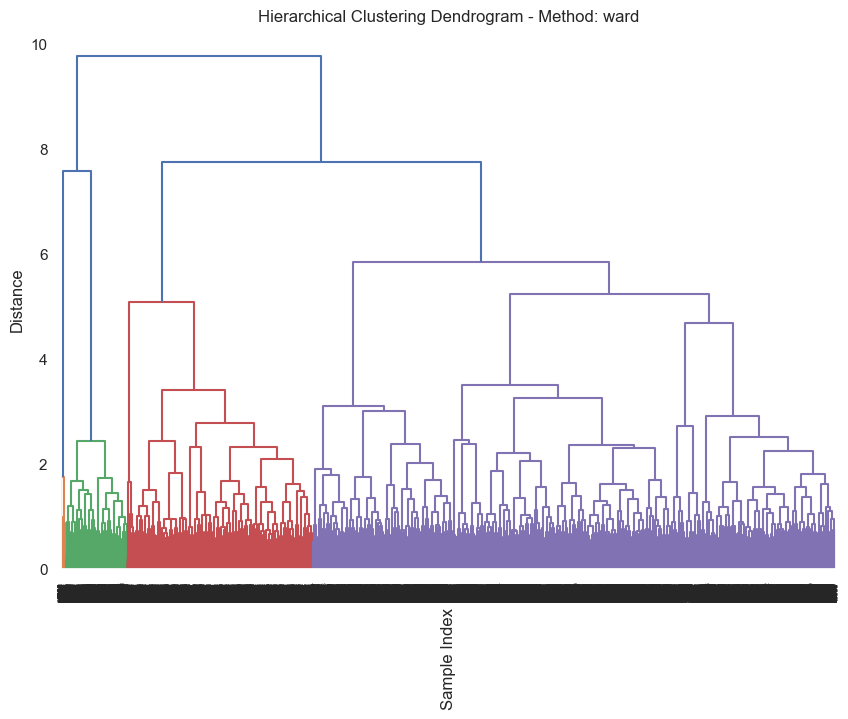

Cluster distribution for method ward:
F_Cluster
2    25113
1     2381
Name: count, dtype: int64


RecursionError: maximum recursion depth exceeded in __instancecheck__

<Figure size 1000x700 with 0 Axes>

In [36]:
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

# Ensure the distance matrix is symmetric
gower_dist_matrix = (gower_dist_matrix + gower_dist_matrix.T) / 2

# Convert to condensed form
condensed_gower_dist = squareform(gower_dist_matrix)

# Try different linkage methods
methods = ['ward', 'single', 'complete', 'average', 'centroid', 'median']

for method in methods:
    # Perform hierarchical clustering with the current method
    linkage_matrix = linkage(condensed_gower_dist, method=method)
    
    # Plot dendrogram
    plt.figure(figsize=(10, 7))
    dendrogram(linkage_matrix)
    plt.title(f'Hierarchical Clustering Dendrogram - Method: {method}')
    plt.xlabel('Sample Index', rotation=90)
    plt.ylabel('Distance')
    plt.show()
    
    # Cut the dendrogram to get exactly 2 clusters
    clusters = fcluster(linkage_matrix, t=2, criterion='maxclust')  # Forces exactly 2 clusters

    # Add cluster labels to the original dataframe
    df['F_Cluster'] = clusters

    # Print the number of samples in each cluster
    print(f"Cluster distribution for method {method}:")
    print(df['F_Cluster'].value_counts())